In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [72]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [161]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect, and_
from sqlalchemy.dialects import sqlite

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [27]:
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for col in m_columns:
    print(f"{col['name']} {col['type']}")

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [28]:
s_columns = inspector.get_columns('station')
for col in s_columns:
    print(f"{col['name']} {col['type']}")

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Precipitation Analysis

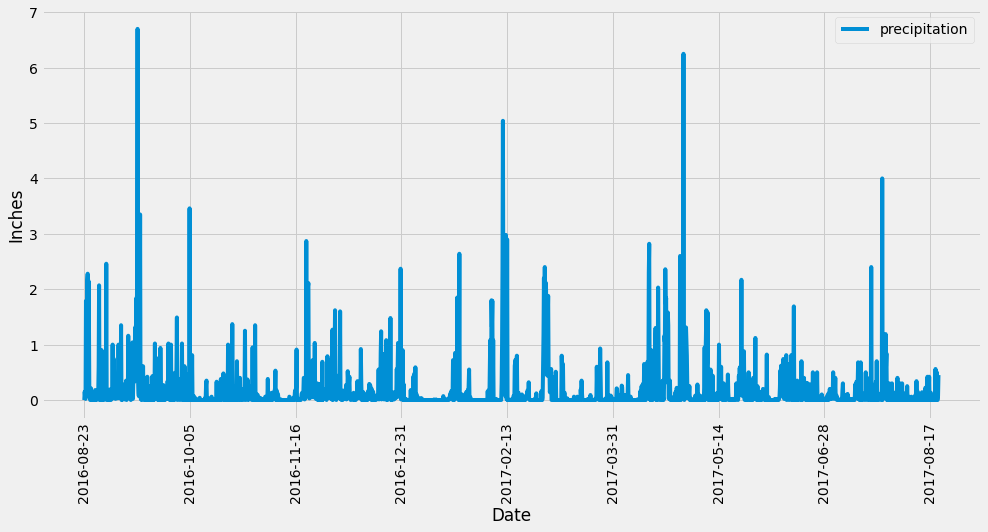

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_list = (
    Query(Measurement)
    .with_entities(func.max(Measurement.date))
    .with_session(session)
    .all()
    )

#Convert the last date to a datetime object
last_date = dt.datetime.strptime((last_date_list[0][0]), "%Y-%m-%d")

#Subtract a year
year_ago = dt.datetime(last_date.year-1, last_date.month, last_date.day)

#Convert back to a string to use in the query
year_ago_str = year_ago.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df_precipitation_analysis = pd.read_sql(f"SELECT measurement.date as date, measurement.prcp as precipitation FROM measurement WHERE measurement.date >= '{year_ago_str}' ORDER BY measurement.date ASC;", engine.connect(), index_col='date')
df_precipitation_analysis

# Drop NaN Values
df_precipitation_analysis_clean = df_precipitation_analysis.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = df_precipitation_analysis_clean.plot(legend=True, rot=90, figsize=(15,7));
ax.set_xlabel('Date');
ax.set_ylabel('Inches');

In [149]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precipitation_analysis_clean.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [153]:
# Design a query to show how many stations are available in this dataset?
station_count = (
    Query(Measurement)
    .with_entities(func.count(Measurement.station.distinct()))
    .with_session(session)
    .all()
    )
station_count

[(9)]

In [158]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]

station_activity = (
    Query(Measurement)
    .with_entities(*sel)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .with_session(session)
    .all()
    )
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [160]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats_sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

temp_stats = (
    Query(Measurement)
    .filter(Measurement.station == 'USC00519281')
    .with_entities(*temp_stats_sel)
    .order_by(func.count(Measurement.tobs).desc())
    .with_session(session)
    .all()
    )
temp_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

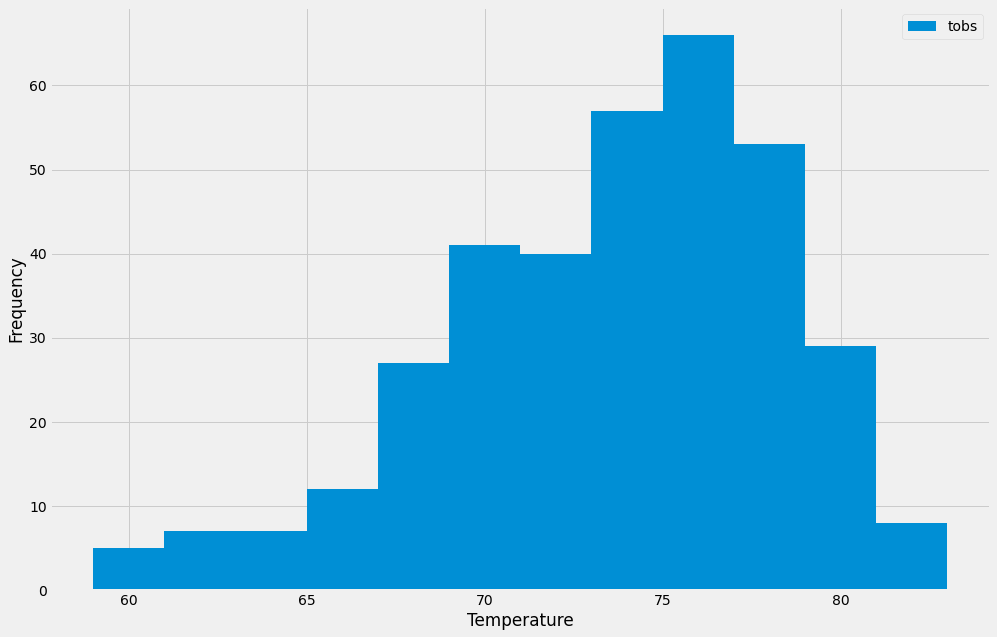

In [179]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps_sel = [Measurement.date, Measurement.tobs]

most_temps = (
    Query(Measurement)
    .filter(and_(Measurement.station == 'USC00519281', Measurement.date >= year_ago_str))
    .with_entities(*most_temps_sel)
    .order_by(Measurement.date.desc())
    .with_session(session)
    .all()
    )
# convert to dataframe
df_most_temps = pd.DataFrame(most_temps)

ax = df_most_temps.plot.hist(bins=12, figsize=(15,10));
ax.set_xlabel('Temperature');

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
